In [1]:
%%HTML
<style> code {background-color : pink !important;} </style>

In [2]:
import cv2
import glob
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt

### camera calibration

In [ ]:
# create obj points 
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# lists of objpoints and image points from images
objpoints = []
imgpoints = []

# list of calibration images
calib_imgs = glob.glob('camera_cal/calibration*.jpg')
# print(len(calib_imgs))

# iterate over images and search for chessboard corners
for idx, fname in enumerate(calib_imgs):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    # if found, add object points and image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
#         print(len(corners))
        # show corners on image
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)
        
cv2.destroyAllWindows()

In [ ]:
%matplotlib inline

# Test undistortion on an image
cal_img = cv2.imread(calib_imgs[2])
cal_img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, cal_img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "car_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [18]:
# if we already have pickle with cam matrix and distortion coefficients
# run only this cell
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "car_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]




### perspective transform 

In [19]:
# prepare list of test images
test_img_dir = "test_images"
test_img_list = os.listdir(test_img_dir)
test_images = []
for i in range(len(test_img_list)):
    img_path = os.path.join(test_img_dir, test_img_list[i])
    test_images.append(mpimg.imread(img_path))

# more complex examples    
h_test_img_dir = "hard_test_images"
h_test_img_list = os.listdir(h_test_img_dir)
h_test_images = []
for i in range(len(h_test_img_list)):
    img_path = os.path.join(h_test_img_dir, h_test_img_list[i])
    h_test_images.append(mpimg.imread(img_path))


In [ ]:
# use interactive window to find points for perspective pransform
und_test_img = cv2.undistort(test_images[0], mtx, dist, None, mtx)
cv2.imshow("undist st_test image", und_test_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
img = mpimg.imread(os.path.join("test_images", test_images[0]))
plt.imshow(img)

In [ ]:
plt.imshow(img)
plt.plot(300, 670, ".")
plt.plot(603, 450, ".")

In [20]:
def show_batch(img_list):
    fig = plt.figure(figsize=(20, 20))
    for i in range(len(img_list)):
        fig.add_subplot(4, 2, i+1)
        plt.imshow(img_list[i])
    plt.show()

def show_batch_grey(img_list):
    fig = plt.figure(figsize=(20, 20))
    for i in range(len(img_list)):
        fig.add_subplot(4, 2, i+1)
        plt.imshow(img_list[i], cmap='gray')
    plt.show()
    
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def undist(img, mtx, dist):
    und_img = cv2.undistort(img, mtx, dist, None, mtx)
    return und_img

def warp_undistorted(img):
    img_size = (img.shape[1], img.shape[0])
    offset = 300
    src = np.float32([[295, 670], [596, 450], [685, 450], [1015, 670]])
    dst = np.float32([[offset, img_size[1]],
                      [offset, 0],
                      [img_size[0]-offset, 0],
                      [img_size[0]-offset, img_size[1]]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size)
#     draw_lines(warped, [[[offset, img_size[1], offset, 0],
#                                        [img_size[0]-offset, 0, img_size[0]-offset, img_size[1]]]])
    return warped, M

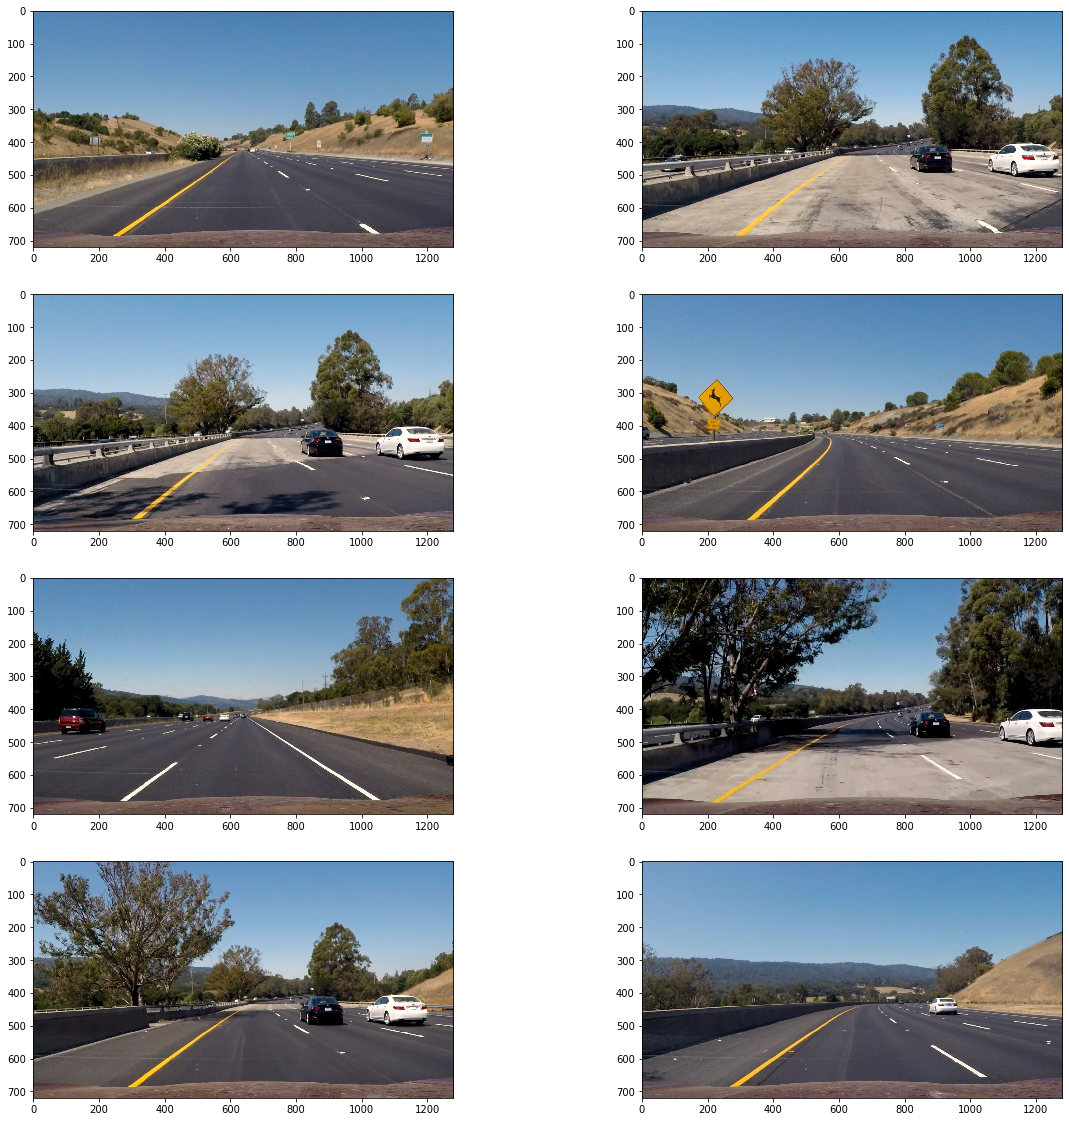

In [21]:
show_batch(test_images)

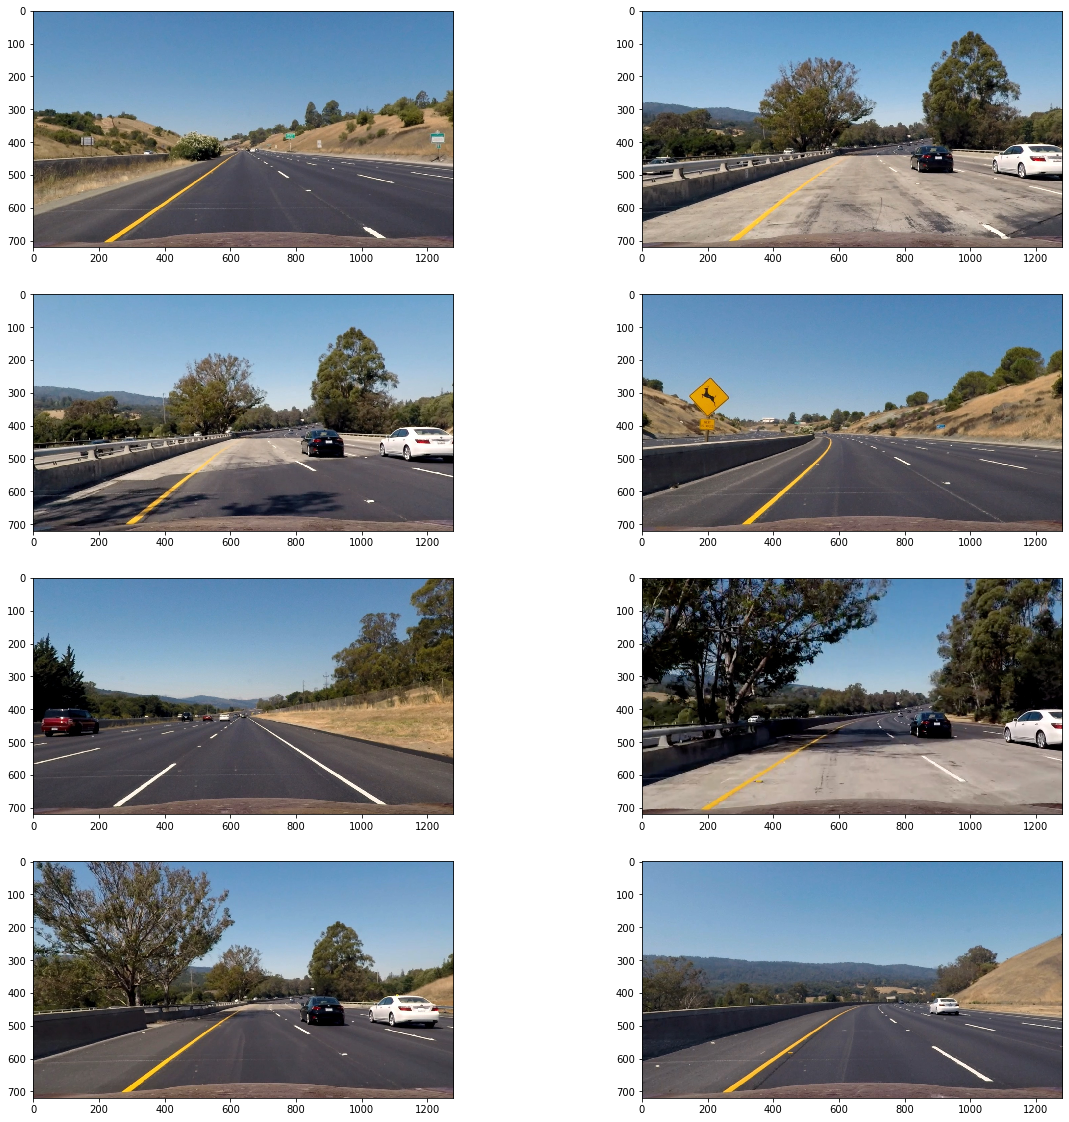

In [22]:
# undistort images
udist_list = []
for i in range(len(test_images)):
    undisted = undist(test_images[i], mtx, dist)
    udist_list.append(undisted)
show_batch(udist_list)

In [23]:
# define color threshold functions
def s_hsl_thresh(img, s_thresh=(0, 255)):
    img = np.copy(img)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel < s_thresh[1])] = 1
    
    return s_binary

def s_hsv_thresh(img, s_thresh=(0, 255)):
    img = np.copy(img)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    s_channel = hsv[:,:,1]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel < s_thresh[1])] = 1
    
    return s_binary

def v_hsv_thresh(img, v_thresh=(0, 255)):
    img = np.copy(img)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh[0]) & (v_channel < v_thresh[1])] = 1
    
    return v_binary

In [ ]:
# compare s channel in hsl with v channel in hsv on test images
def compare(img_list):
    for img in img_list:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()

        ax1.imshow(s_hsl_thresh(img, (170, 255)), cmap='gray')
        ax1.set_title('s_hsl_thresh', fontsize=40)

        ax2.imshow(v_hsv_thresh(img, (215, 255)), cmap='gray')
        ax2.set_title('v_hsv_thresh', fontsize=40)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

compare(test_images)

In [ ]:
# compare s channel in hsl with v channel in hsv on test images
def compare(img_list):
    for img in img_list:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()

        ax1.imshow(s_hsl_thresh(img, (170, 255)), cmap='gray')
        ax1.set_title('s_hsl_thresh', fontsize=40)

        ax2.imshow(v_hsv_thresh(img, (215, 255)), cmap='gray')
        ax2.set_title('v_hsv_thresh', fontsize=40)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

compare(test_images)

In [ ]:
# compare s channel in hsl with v channel in hsv on hard test images
# right compare function

def compare(func1, args1, func2, args2):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        
        ax1.imshow(func1(*args1), cmap='gray')
        ax1.set_title('func1', fontsize=40)

        ax2.imshow(func2(*args2), cmap='gray')
        ax2.set_title('func2', fontsize=40)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
for image in test_images:
    compare(s_hsl_thresh, (image, (0, 255)), v_hsv_thresh, (image, (0, 255)))

In [ ]:
v_hsv_list = []
for image in test_images:
    v_hsv_list.append(v_hsv_thresh(image, (225, 255)))
show_batch_grey(v_hsv_list)

In [24]:
# define gradient threshold functions
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate gradient direction
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = np.abs(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # scale 
    scaled_sobel = np.abs(np.uint8(255*sobel/np.max(sobel)))
    # Apply threshold
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel <= thresh[1]) & (scaled_sobel >= thresh[0])] = 1
    
    return grad_binary

def h_mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # calculate gradient magnitude
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag_sobel = np.sqrt(np.square(sobelX) + np.square(sobelY))
    # scale
    scaled_mag = np.uint8(255*mag_sobel/np.max(mag_sobel))
    # apply threshold
    mag_binary = np.zeros_like(scaled_mag)
    mag_binary[(scaled_mag >= thresh[0]) & (scaled_mag <= thresh[1])] = 1
    
    return mag_binary

def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # calculate gradient direction
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    dir_sobel = np.arctan2(np.abs(sobelY), np.abs(sobelX))
    # apply threshold
    dir_binary = np.zeros_like(dir_sobel)
    dir_binary[(dir_sobel >= thresh[0]) & (dir_sobel <= thresh[1])] = 1

    return dir_binary

In [ ]:
# compare x dir grad and  y dir grad on test images

for image in test_images:
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(abs_sobel_thresh(image, orient='x', sobel_kernel=5, thresh=(30, 100)), cmap='gray')
    ax1.set_title('sobel_x', fontsize=40)

    ax2.imshow(abs_sobel_thresh(image, orient='y', sobel_kernel=5, thresh=(30, 100)), cmap='gray')
    ax2.set_title('sobel y', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



In [ ]:
# compare x dir grad and  y dir grad on test images

for image in test_images:
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(abs_sobel_thresh(image, orient='x', sobel_kernel=5, thresh=(30, 100)), cmap='gray')
    ax1.set_title('sobel_x', fontsize=40)

    ax2.imshow(abs_sobel_thresh(image, orient='y', sobel_kernel=5, thresh=(30, 100)), cmap='gray')
    ax2.set_title('sobel y', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



In [ ]:
# compare mag dir grad and  y dir grad on test images

for image in test_images:
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(h_mag_thresh(image, sobel_kernel=5, thresh=(30, 150)), cmap='gray')
    ax1.set_title('h_mag_thresh', fontsize=40)

    ax2.imshow(dir_thresh(image, sobel_kernel=5, thresh=(0.7, 1.2)), cmap='gray')
    ax2.set_title('dir_thresh', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



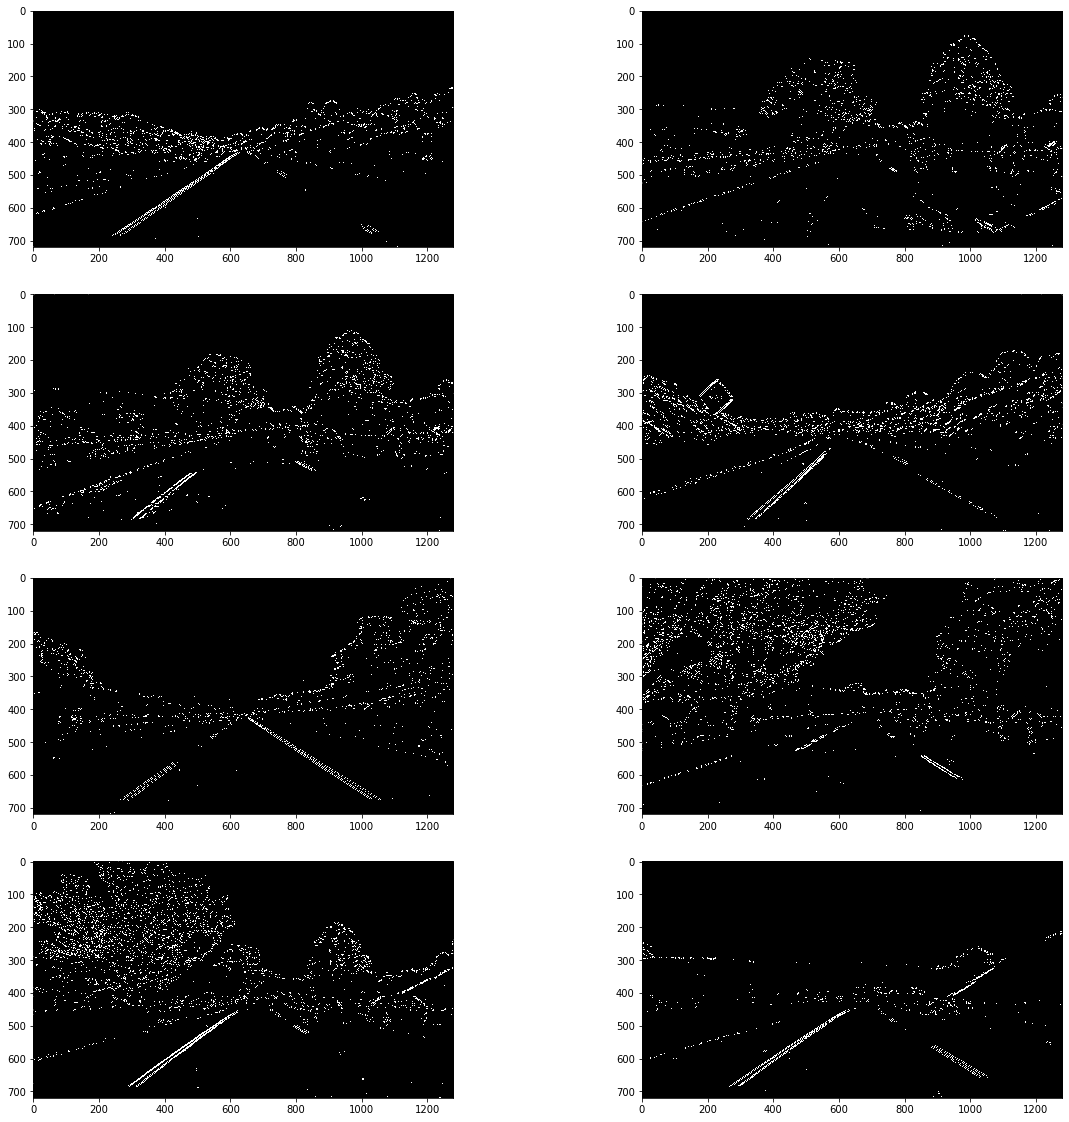

In [25]:
ksize = 9

def comb_grad(img):
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(30, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(30, 100))
    mag_binary = h_mag_thresh(img, sobel_kernel=ksize, thresh=(30, 150))
    dir_binary = dir_thresh(img, sobel_kernel=ksize, thresh=(0.7, 1.2))


    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) | (grady == 1)) & ((mag_binary == 1) & (dir_binary == 1))] = 1
#     combined[((gradx == 1) | (grady == 1)) ] = 1 # norm
#    combined[((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

comb_grad_list = []
for image in test_images:
    comb_grad_list.append(comb_grad(image))

show_batch_grey(comb_grad_list)

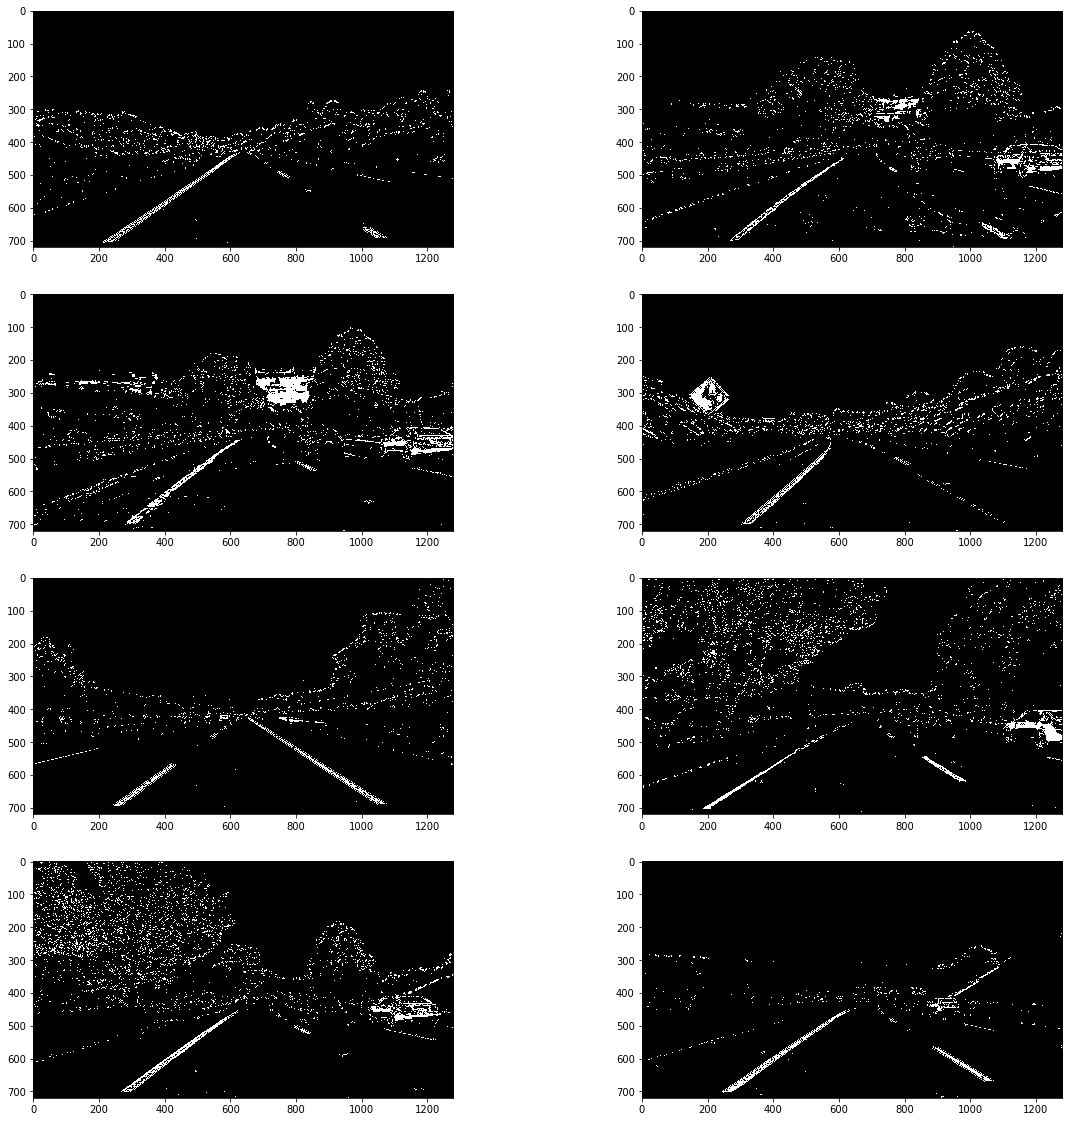

In [26]:
def threshold(img):
    v_hsv = v_hsv_thresh(img, (225, 255))
    grad = comb_grad(img)
    combined = np.zeros_like(v_hsv)
    
    combined[((v_hsv == 1) | (grad == 1))] = 1
    return combined
# use combined threshold
threshold_list = []
for image in udist_list:
    threshold_list.append(threshold(image))
show_batch_grey(threshold_list)

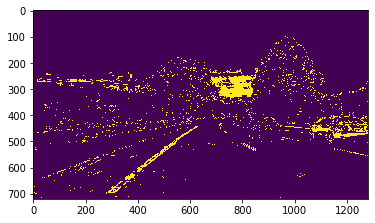

In [16]:
plt.figure()
plt.imshow(threshold_list[2])

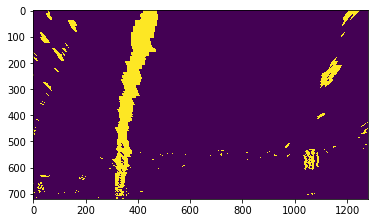

In [28]:
plt.figure()
img_to_show, M = warp_undistorted(threshold_list[2])
plt.imshow(img_to_show)

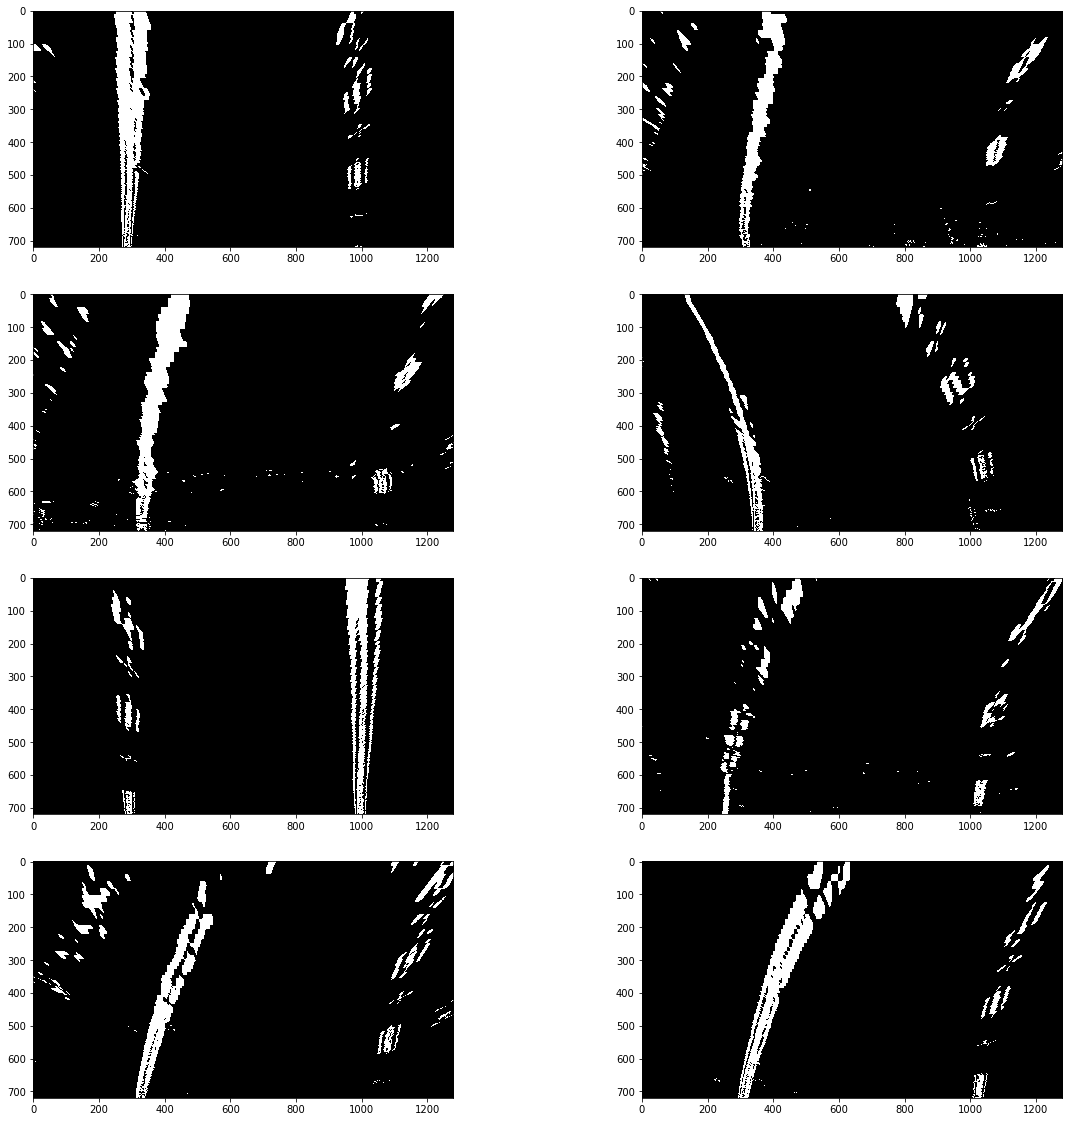

In [29]:
# use perspective transform
warped_cal_list = []
for image in threshold_list:
    warped, M = warp_undistorted(image) 
    warped_cal_list.append(warped)

show_batch_grey(warped_cal_list)

### histogram

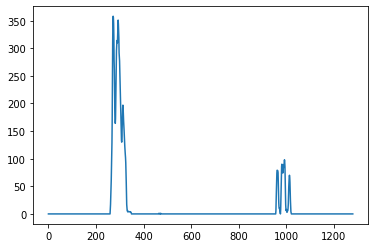

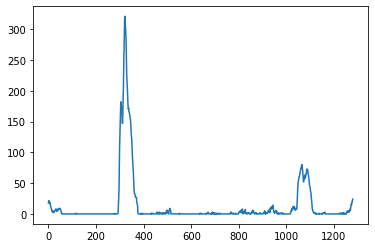

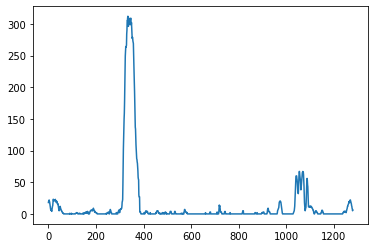

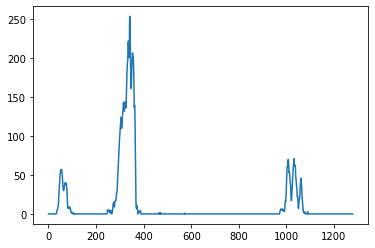

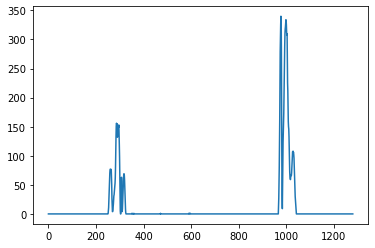

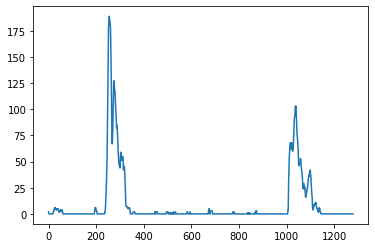

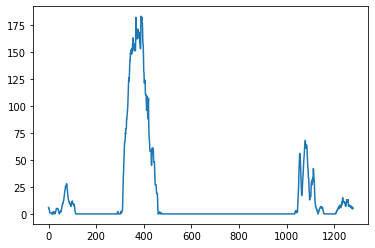

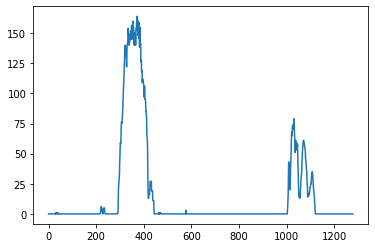

In [30]:
def histogram(img):
    return np.sum(img[img.shape[0]//2:,:], axis=0)
for image in warped_cal_list:
    plt.figure()
    plt.plot(histogram(image))

In [31]:
def find_lines(img):
    # split histogram into left and right
    # create histogram
    hist = np.sum(img[img.shape[0]//2:,:], axis=0)

    # create output img
    out_img = np.dstack((img, img, img))*255

    # find left and right pead on hist
    mid_p = np.int(hist.shape[0]//2)
    # first poinst of the lines
    leftx_base = np.argmax(hist[0:mid_p])
    rightx_base = np.argmax(hist[mid_p:]) + mid_p

    # sliding window hyperparams
    # number of the sliding windows
    n_windows = 9
    # width is +/- margin
    margin = 100
    # min number of pixels to recenter window
    minpix = 50

    # set window height
    h_window = np.int(img.shape[0]//n_windows)
    # indentify all non zero pixels and split x and y
    nonzero = img.nonzero()
    #print(f'nonzero len is {len(nonzero)}')
    #print(nonzero)
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    # start current pos 
    leftx_cur = leftx_base
    rightx_cur = rightx_base
#     print(f"started left x is {leftx_cur} and right x is {rightx_cur}")

    # left and right index list to receive lane pixels
    left_lane_inds = []
    right_lane_inds = []

    for window in range(n_windows):
#         print(f"current window is {window}")
        win_low_y = img.shape[0] - (window + 1) * h_window
        win_high_y = img.shape[0] - (window) * h_window
        win_left_low_x = leftx_cur - margin
        win_left_high_x = leftx_cur + margin
        win_right_low_x = rightx_cur - margin
        win_right_high_x = rightx_cur + margin
#         print(f'left {win_left_low_x} {win_low_y} and {win_left_high_x} {win_high_y}')
        # draw  window rectangle 
        # left
#         cv2.rectangle(out_img, (win_left_low_x, win_low_y), (win_left_high_x, win_high_y), (0,0,255), 2)
        # right
#         cv2.rectangle(out_img, (win_right_low_x, win_low_y), (win_right_high_x, win_high_y), (0,255,0), 2)
        # find nonzero indexes in windows
        good_left_inds = ((nonzeroy >= win_low_y) & (nonzeroy < win_high_y) &
                          (nonzerox >= win_left_low_x) & (nonzerox < win_left_high_x)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_low_y) & (nonzeroy < win_high_y) &
                           (nonzerox >= win_right_low_x) & (nonzerox < win_right_high_x)).nonzero()[0]

        # append inds to the lines
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # recented window if  many pixels
        if len(good_left_inds) > minpix:
                leftx_cur = np.int(np.mean(nonzerox[good_left_inds]))
#                 print(f" current leftx is {leftx_cur}")
        if len(good_right_inds) > minpix:
                rightx_cur = np.int(np.mean(nonzerox[good_right_inds]))
#                 print(f" current rightx is {rightx_cur}")

    # concat array of indices
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    # find left and right pixel poses
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty # return separate x, y of the lines and out_img

In [37]:
def find_poly(img_shape, linex, liney):
    # find coefficient for curv throught lane points
    fit = np.polyfit(liney, linex, 2) # x, y and polinome power
    # generate y points for plotting the line
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0]) # from, to, number of points
    # calculate polinominals 
    try:
        polx = fit[0] * ploty**2 + fit[1] * ploty + fit[2]
    except TypeError:
        # Avoids an error if `fit` are still none or incorrect
        print('The function failed to fit a line!')
        polx = 1*ploty**2 + 1*ploty
        
    return fit, polx, ploty

In [43]:
def draw_poly_bin(binary_warped, left_fitx, right_fitx, ploty, show_search=False):
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    result = out_img
    if show_search == True:
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
       
    return result

In [121]:
def search_near_poly(bin_img, left_polx, right_polx):
    #define margin (wide of the tube around polyline)
    margin = 100
    
    # take nonzero (ie 1 in bin image) pixels
    nonzero = bin_img.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    
    # define area for search poly +/- margin
    left_lin_inds = ((nonzerox > (left_polx[0]*(nonzeroy**2) + 
                                  left_polx[1]*nonzeroy + left_polx[2] - margin)) &
                     (nonzerox < (left_polx[0]*(nonzeroy**2) + 
                                  left_polx[1]*nonzeroy + left_polx[2] + margin)))
    right_lin_inds = ((nonzerox > (right_polx[0]*(nonzeroy**2) + 
                                   right_polx[1]*nonzeroy + right_polx[2] - margin)) &
                     (nonzerox < (right_polx[0]*(nonzeroy**2) + 
                                   right_polx[1]*nonzeroy + right_polx[2] + margin)))
    # find left and right pixel poses
    leftx = nonzerox[left_lin_inds]
    lefty = nonzeroy[left_lin_inds]
    rightx = nonzerox[right_lin_inds]
    righty = nonzeroy[right_lin_inds]
    
    return leftx, lefty, rightx, righty

39383
left_coef [ 2.40081304e-04 -3.35030835e-01  4.50023269e+02]
left curvrd is 2411.9315116847056, right curvrd is 2783.220763311669


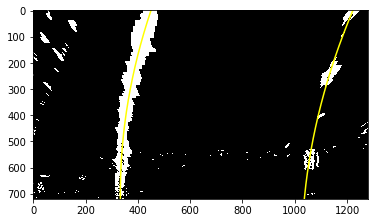

In [129]:
use_img = warped_cal_list[2]
leftx, lefty, rightx, righty = find_lines(use_img)
print(len(leftx))
#left line
left_coef, left_polx, left_poly = find_poly(use_img.shape, leftx, lefty)
print(f"left_coef {left_coef}")
right_coef, right_polx, right_poly = find_poly(use_img.shape, rightx, righty)
img_show = draw_poly_bin(use_img, left_polx, right_polx, right_poly)
leftcurvrd, rightcurvrd = measure_curv(left_coef, right_coef, right_poly)
print(f"left curvrd is {leftcurvrd}, right curvrd is {rightcurvrd}")
# plt.figure(figsize=(20,10))
plt.imshow(img_show)

[371 371 371 ... 719 719 719]
left_coef1 is [-2.76918015e-04  4.53191802e-01  1.71834871e+02]
left curvrd is 2345.7310565710936, right curvrd is 1360.6799254424434


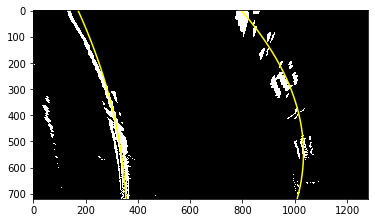

In [130]:
use_img1 = warped_cal_list[3]
leftx1, lefty1, rightx1, righty1 = search_near_poly(use_img1, left_coef, right_coef)
print(righty1)
left_coef1, left_polx1, left_poly1 = find_poly(use_img.shape, leftx1, lefty1)
print(f"left_coef1 is {left_coef1}")
right_coef1, right_polx1, right_poly1 = find_poly(use_img.shape, rightx1, righty1)
img_show1 = draw_poly_bin(use_img1, left_polx1, right_polx1, right_poly1)
leftcurvrd1, rightcurvrd1 = measure_curv(left_coef1, right_coef1, right_poly1)
print(f"left curvrd is {leftcurvrd1}, right curvrd is {rightcurvrd1}")
# plt.figure(figsize=(20,10))
plt.imshow(img_show1)

In [50]:
def measure_curv(left_fit, right_fit, ploty):
    # set point there we want to measure curvature
    # It is bottom of the image because there is our camera on birdview
    y_eval = np.max(ploty)
#     print(left_polx)
#     print("-----------")
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # convert coefficients form pixels to meters
    y_eval_m = y_eval * ym_per_pix
#     map(lambda x : x*xm_per_pix, left_polx)
#     print(left_polx)
#     right_polx_m = map(lambda x : x*xm_per_pix, right_polx)
#     print(y_eval)
    
    left_curvrad = ((1 + (2*left_fit[0]*y_eval_m + left_fit[1])**2)**1.5) / np.abs(2*left_fit[0])
    right_curvrad = ((1 + (2*right_fit[0]*y_eval_m + right_fit[1])**2)**1.5) / np.abs(2*right_fit[0])
    
    return left_curvrad, right_curvrad

In [ ]:
left_polximage = warped_cal_list[7]
leftLinex, leftLiney, rightLinex, rightLiney = find_lines(image)
left_polx, lpoly = poly_fit(image.shape, leftLinex, leftLiney)
right_polx, rpoly = poly_fit(image.shape, rightLinex, rightLiney)



image2 = warped_cal_list[7]
leftLinex2, leftLiney2, rightLinex2, rightLiney2 = search_around_poly(image, left_polx, right_polx,)
left_polx2, lpoly2 = poly_fit(image.shape, leftLinex2, leftLiney2)
right_polx2, rpoly2 = poly_fit(image.shape, rightLinex2, rightLiney2)


### make pipeline

In [146]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):    
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        # 
        self.restart()
    
    def restart(self):
        print("line restarted")
        # line was found in previous image
        self.was_detected = False
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # list of last 5 poly coefficients
        self.last_five_fits = []
        # radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # distance in meters of vehicle center from the line
        self.line_base_pos = None 
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        # current curv pounts
        self.polx = None
        # current ploty
        self.ploty = None
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None  
        # counter for false detection
        # if more, restart the line
        self.count = 0
        
    def add_fit(self, fit):
        self.current_fit = fit
#         print("i'm add fit")
        if len(self.last_five_fits) < 5:
            self.last_five_fits.append(fit)
        elif len(self.last_five_fits) == 5:
            self.last_five_fits.pop(0)
            self.last_five_fits.append(fit)
    
    
    def count_check(self):
        if self.count > 5:
            self.restart()
            
            
    def poly_draw(self):
        pass



dist_pickle = pickle.load( open( "car_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
left_line = Line()
right_line = Line()

def pipeline(img, mtx, dist):
    #undistort image
    undisted = undist(img, mtx, dist)
    # apply combined color and gradient threshold
    tresh = threshold(undisted)
    # change persperctine to birdview
    warped_thresh, M = warp_undistorted(tresh)
    
    
    # if we have not lines use sliding window
    if left_line.was_detected is False or right_line.was_detected is False:
        # find points of lines by sliding window
        leftx, lefty, rightx, righty = find_lines(warped_thresh)
#         print("i fond some by sliding window")
#         print(f"len of leftx is {len(leftx)}")
#         print(f"len of rightx is {len(rightx)}")
#         print(f"len of lefty is {len(lefty)}")
#         for i in range(len(leftx)):
#             print(leftx[i], "      ", lefty[i])
    # if we already have lines from previous image 
    elif left_line.was_detected is True and right_line.was_detected is True:
        # use search near poly
        leftx, lefty, rightx, righty = search_near_poly(warped_thresh, 
                                                             left_line.current_fit, right_line.current_fit)
#         plt.figure()
#         plt.imshow(img)
#         print("found something by search near poly")
#         print(f"len of leftx is {len(leftx)}")
#         print(f"len of rightx is {len(rightx)}")
#         print(f"len of lefty is {len(lefty)}")
#         print("leftx and lefty")

    # TO-DO if find fault we need to drop image and +1 counter in class
    if len(rightx) > 0 and len(righty) > 0:
        # set was detected
        right_line.was_detected = True
#         print("right line was detected")
        # add founded points to instanse
        right_line.allx = rightx
        right_line.ally = righty
        # add poly 
        l_fit, right_line.polx, right_line.ploty = find_poly(warped_thresh.shape,right_line.allx, right_line.ally)
        right_line.add_fit(l_fit)
#         print(f"currend fit is {right_line.current_fit}")
    else:
        right_line.count += 1 
#         print(f"right line was dropend for the {right_line.count} time")
    # if find points of left line
    if len(leftx) > 0 and len(lefty) > 0:
        # set was detected
        left_line.was_detected = True
#         print("left line was detected")
        # add founded points to instanse
        left_line.allx = leftx
        left_line.ally = lefty
        # add poly 
        r_fit, left_line.polx, left_line.ploty = poly_fit(warped_thresh.shape,left_line.allx, left_line.ally)
        left_line.add_fit(r_fit)
#         print(f"current fit is {left_line.current_fit}")
    else:
        left_line.count += 1
    left_line.count_check()
    right_line.count_check()
    # if found point of right line

    
    # measure curvature 
#     print("lets measure curvature")
#     print(left_line.current_fit)
    left_curvrd, right_curvd = measure_curv(left_line.current_fit, right_line.current_fit, left_line.ploty)
    avg_curvrd = round(np.mean([left_curvrd,right_curvd]), 0)
    curv_text = f"current radius of  curvature is {avg_curvrd}"
    
    font = cv2.FONT_HERSHEY_PLAIN
    cv2.putText(undisted, curv_text, (10,100), font, 1, (255,255,255), 2)
    #Draving lines
    # invert matrix of tranfer
    Minv = np.linalg.inv(M)
    

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_thresh).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_line.polx, left_line.ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.polx, right_line.ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undisted, 1, newwarp, 0.3, 0)
    return result

line restarted
line restarted


current image is 0
current image is 1
current image is 2
current image is 3
current image is 4
current image is 5
current image is 6
current image is 7


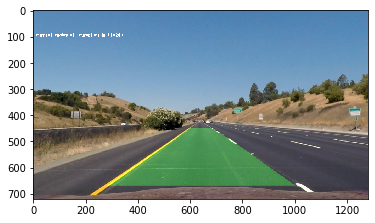

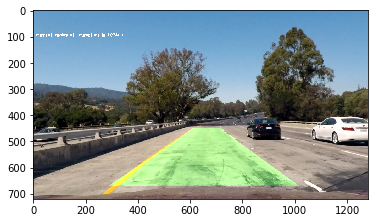

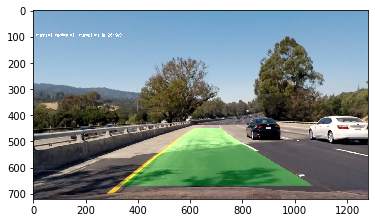

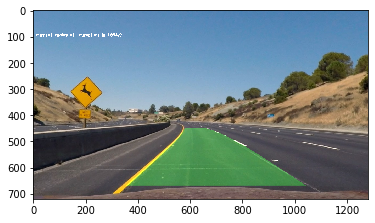

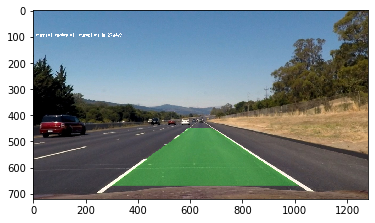

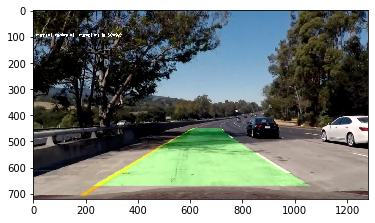

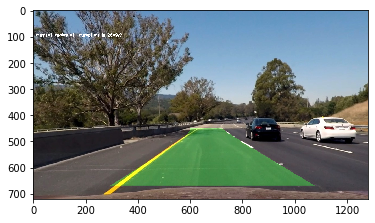

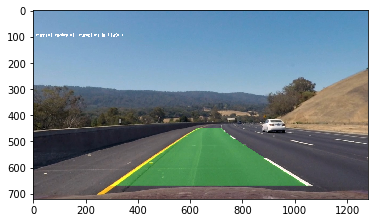

In [145]:
for idx, image in enumerate(test_images):
    print(f"current image is {idx}")
    plt.figure()
    plt.imshow(pipeline(image, mtx, dist))

In [147]:
import imageio

imageio.plugins.ffmpeg.download

imageio.plugins.ffmpeg.download()
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = pipeline(image, mtx, dist)
    return result

In [148]:
output = 'project_output_short.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video_short.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_output_short.mp4
[MoviePy] Writing video project_output_short.mp4



 25%|██▍       | 155/621 [01:06<03:18,  2.34it/s]


 50%|████▉     | 309/621 [02:11<02:09,  2.41it/s]


 75%|███████▍  | 463/621 [03:14<01:07,  2.33it/s]


 99%|█████████▉| 617/621 [04:15<00:01,  2.51it/s]


100%|█████████▉| 620/621 [04:16<00:00,  2.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_short.mp4 

CPU times: user 44min 20s, sys: 43 s, total: 45min 3s
Wall time: 4min 17s


In [ ]:
image = udist_list[1]
curv_text = "some text to image"
font = cv2.FONT_HERSHEY_PLAIN
cv2.putText(image, curv_text, (10,100), font, 1, (255,255,255), 2)
plt.imshow(image)